### IMPORT LIBRARIES

In [25]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

### SOURCE PATH 

In [26]:
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-06-22 09:26:00--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.68.33, 2600:1402:800:2a8::e59, 2600:1402:800:2ac::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.36.68.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   192MB/s    in 4.2s    

2020-06-22 09:26:05 (189 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [27]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


### MAKE DIRECTORIES

In [28]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

### SPLITTING TRAIN AND TEST DATA

In [29]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    for files in os.listdir(SOURCE): 
        FILE_NAME = SOURCE + files 
        if os.path.getsize(FILE_NAME) > 0: 
            all_files.append(files)

    dataset_size = int(len(all_files))
    train_size = int(dataset_size * SPLIT_SIZE)
    
    shuffled_list = random.sample(all_files, dataset_size)
    train_set = shuffled_list[0 : train_size]
    test_set = shuffled_list[train_size : dataset_size]

    for files in train_set: 
        copyfile(SOURCE + files, TRAINING + files)
    for files in test_set: 
        copyfile(SOURCE + files, TESTING + files)

### LOAD DIRECTORIES AND SPLIT THEIR DATA INTO TRAIN AND TEST SETS

In [30]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

12500
12499
5136
5101


### SEQUENTIAL MODEL CREATION WITH FOUR 3x3 CONVOLUTIONS

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(150, 150, 3)), 
    tf.keras.layers.MaxPooling2D((2,2)), 

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D((2,2)), 

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D((2,2)), 
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D((2,2)), 
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation = 'relu'), 
    
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])


### COMPILE MODEL 

In [36]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc']) 

### IMAGE PREPROCESSING USING ImageDataGenerator 
#### flow_from_directory for file path inclusion

In [37]:
TRAINING_DIR = "/tmp/cats-v-dogs/training"
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest'
                                  )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    target_size = (150, 150), 
                                                    class_mode = 'binary', 
                                                    batch_size = 10)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                            target_size = (150, 150), 
                                                            class_mode = 'binary', 
                                                            batch_size = 10)

Found 24997 images belonging to 2 classes.
Found 10236 images belonging to 2 classes.


### FIT THE MODEL

In [38]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=25,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/25
100/100 - 59s - loss: 0.7203 - acc: 0.5400 - val_loss: 0.6877 - val_acc: 0.5560
Epoch 2/25
100/100 - 59s - loss: 0.7014 - acc: 0.5210 - val_loss: 0.6815 - val_acc: 0.5600
Epoch 3/25
100/100 - 59s - loss: 0.6959 - acc: 0.5540 - val_loss: 0.6787 - val_acc: 0.5300
Epoch 4/25
100/100 - 59s - loss: 0.6881 - acc: 0.5380 - val_loss: 0.6851 - val_acc: 0.5640
Epoch 5/25
100/100 - 59s - loss: 0.6820 - acc: 0.5550 - val_loss: 0.6649 - val_acc: 0.6420
Epoch 6/25
100/100 - 59s - loss: 0.6764 - acc: 0.6180 - val_loss: 0.6535 - val_acc: 0.5960
Epoch 7/25
100/100 - 59s - loss: 0.6911 - acc: 0.5760 - val_loss: 0.6439 - val_acc: 0.6660
Epoch 8/25
100/100 - 59s - loss: 0.6670 - acc: 0.6150 - val_loss: 0.6245 - val_acc: 0.6460
Epoch 9/25
100/100 - 59s - loss: 0.6771 - acc: 0.6330 - val_loss: 0.6274 - val_acc: 0.6620
Epoch 10/25
100/100 - 59s - loss: 0.6583 - acc: 0.6460 - val_loss: 0.6379 - val_acc: 0.6400
Epoch 11/25
100/100 - 60s - loss: 0.6411 - acc: 0.6420 - val_loss: 0.6349 - val_acc: 0.64

### PLOT RESULTS

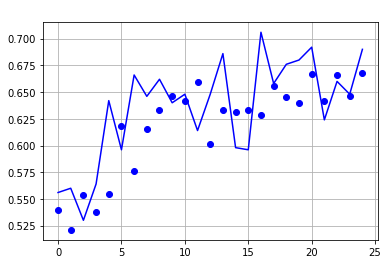

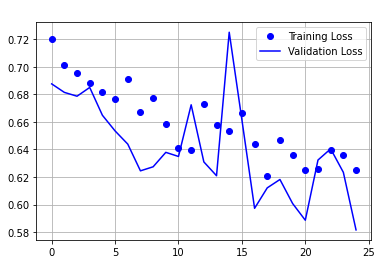

In [41]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', color = 'white')
plt.grid()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss', color = 'white')
plt.grid()
plt.legend()

plt.show()